In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf   #  한글폰트

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('./drive/MyDrive/Colab Notebooks/Competition/KED 대상팀')

In [ ]:
# library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 


from tqdm import tqdm_notebook
from tqdm import tqdm
import re
import nltk
from pprint import pprint

from sklearn.model_selection import train_test_split
from operator import itemgetter

import warnings
warnings.filterwarnings('ignore')
import math

# from konlpy.tag import Mecab  # tok
# mecab = Mecab()

from sklearn.feature_extraction.text import TfidfVectorizer   # vec
# import fasttext

# modeling
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dense, LSTM, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

- 전체 train data는 **1712만개**
- 한 회사에 여러 업종코드가 매핑되어있고, 회사의 개수는 162만개정도 된다
- 한 회사에 할당된 사업목적 분포는 평균 130개 정도 되고, 많게는 400개가 넘어가는 것도 있다. 


- 업종코드를 예측해야하므로 **Label encoding** 과정이 필요해보인다(multi classification)

- 업종코드가 'nan'이라고 표시되어있는 것들이 10만개정도 존재한다 
> 삭제해도될듯



```
- 대분류 개수 barplot
- 중분류 개수 barplot(unbalanced 함을 강조)
- 대분류끼리 자카드 계수 
- 대분류별 워드클라우드
- 토큰 길이 boxplot
- 회사별 사업목적 개수 boxplot
```



In [ ]:
data = pd.read_pickle('./data/final_data/0521_ked_train_only(full_leastleast_update_token).pkl')  
## 토큰화 한 최종 데이터 

In [ ]:
test = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/0522_ked_test_noun.pkl')

# 1. 대분류끼리 자카드계수

In [ ]:
data.head(1)

,company,purpose,industry_code,is_train,len,big,middle,small,least,leastleast,token,token_len,token2
0,1,"1. 창고업,2. 써비스업,3. 부동산 임대업,4. 자동차 부품 제조업,5. 각호에...",G45211,1,6,G,45,452,4521,45211,"[창고업, 서비스, 부동산, 임대업, 자동차, 부품, 제조업, 부대, 사업]",9,창고업 비스 부동산 임대업 자동차 부품 제조업 부대 사업


In [ ]:
# data = ked_train
A = data.query('big =="A"').copy()
B = data.query('big =="B"').copy()
C = data.query('big =="C"').copy()
D = data.query('big =="D"').copy()
E = data.query('big =="E"').copy()
F = data.query('big =="F"').copy()
G = data.query('big =="G"').copy()
H = data.query('big =="H"').copy()
I = data.query('big =="I"').copy()
J = data.query('big =="J"').copy()
K = data.query('big =="K"').copy()
L = data.query('big =="L"').copy()
M = data.query('big =="M"').copy()
N = data.query('big =="N"').copy()
P = data.query('big =="P"').copy()
Q = data.query('big =="Q"').copy()
R = data.query('big =="R"').copy()
S = data.query('big =="S"').copy()

In [ ]:
def grouping_word(tok_purpose):
  total_tok_purpose = []
  for data in tok_purpose:
    total_tok_purpose+=data
  return set(total_tok_purpose)

In [ ]:
# 대그룹 별 토큰 모아 하나의 집합으로 만들기 (word 기준)
mydata_name = ['A', 'B', 'C','D', 'E', 'F', 'G', 'H','I', 'J','L', 'M', 'N','P', 'Q', 'R', 'S', 'K']
mydata = [A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S]
group_mydata=[]
for dat,data_name in tqdm_notebook(zip(mydata,mydata_name)):
  locals()["group_tok_"+data_name] = grouping_word(dat['token'])
  group_mydata.append(locals()["group_tok_"+data_name])

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# 자카드 계수 계산식
def jaccard(a,b):
    return len(a&b)/len(a|b)

# 그룹별 토큰화 데이터 list => 자카드 matrix 계산
def jaccard_matrix(mydata):
  jaccard_m= [[0] * len(mydata) for _ in range(len(mydata))]
  for i,data1 in enumerate(mydata):
    for j,data2 in enumerate(mydata):
      if i!=j:
        jaccard_val = jaccard(data1,data2)
        jaccard_m[i][j] = jaccard_val
  return jaccard_m

In [ ]:
tok_mydata = [group_tok_A, group_tok_B, group_tok_C, group_tok_D, group_tok_E, group_tok_F, group_tok_G, group_tok_H, group_tok_I,group_tok_J,group_tok_K,group_tok_L, group_tok_M, group_tok_N,group_tok_P, group_tok_Q, group_tok_S, group_tok_R]
jm = jaccard_matrix(tok_mydata)

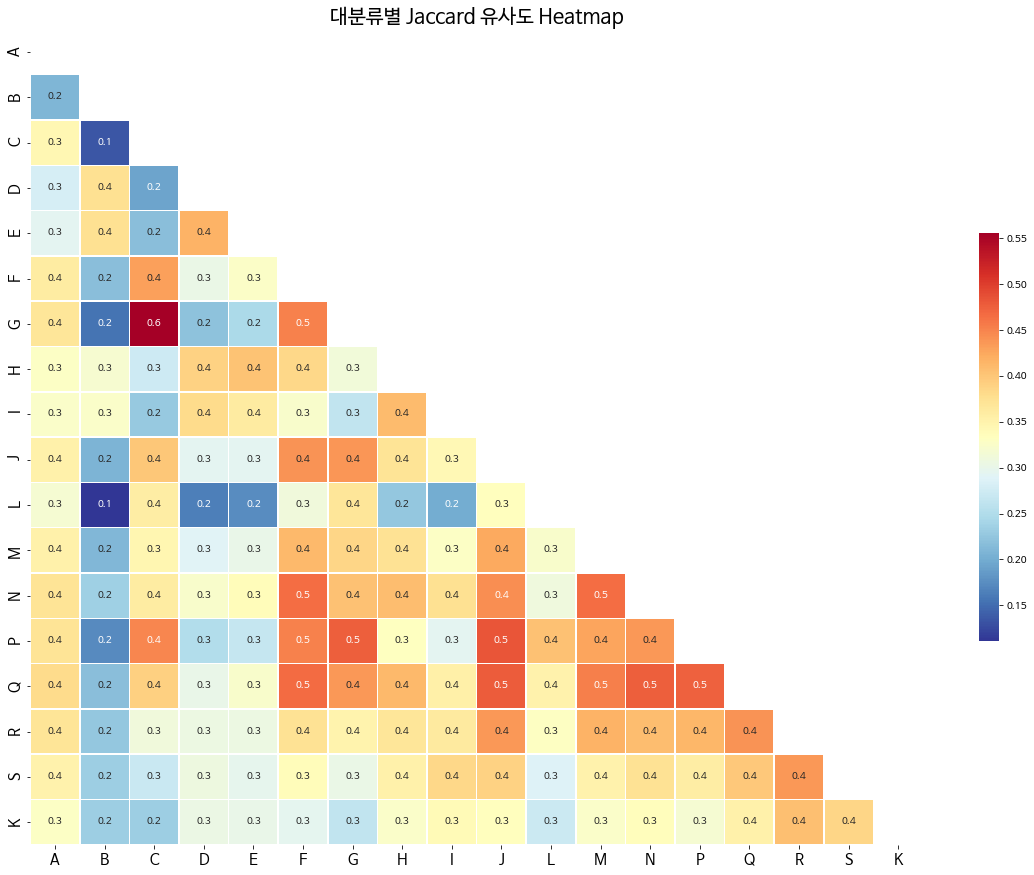

In [ ]:
# cmap = "YlGnBu",
plt.figure(figsize=(20,15))
mask = np.zeros_like(jm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(jm, 
            cmap = 'RdYlBu_r',
            xticklabels = mydata_name, yticklabels = mydata_name,
            annot=True,
            linewidths=.5,
            mask=mask, 
            cbar_kws={"shrink": .5},
            fmt='.1f')
plt.title('대분류별 Jaccard 유사도 Heatmap', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# 2. 대분류별 워드클라우드

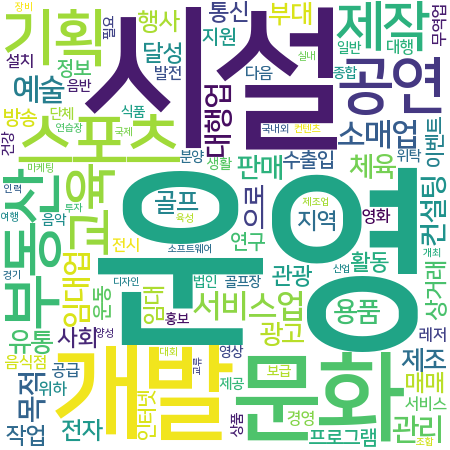

In [ ]:
# unlist
ff = data.query('big=="R"')   # 건설업만 우선 봄
token_map = ff[['company', 'token']]

plylst_song_map_unnest = np.dstack(
    (
        np.repeat(ff.company.values, list(map(len, token_map .token))), 
        np.concatenate(token_map.token.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
token_map  = pd.DataFrame(data = plylst_song_map_unnest[0], columns = token_map.columns)
token_map['company'] = token_map['company'].astype(str)
token_map['token'] = token_map['token'].astype(str)
token_map = token_map.query('token!="사업" & token!="판매업"')

# unnest 객체 제거
del plylst_song_map_unnest

 # 태그 별 매핑 빈도 수 저장 
from wordcloud import WordCloud
tag_cnt = token_map.groupby('token').token.count().reset_index(name = 'mapping_cnt')
tag_cnt['token'] = tag_cnt['token'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['token'], tag_cnt['mapping_cnt']))


# plotting
path = './data/NanumSquare_acB.ttf'
wc = WordCloud(font_path = path, background_color = 'white', collocations=False, max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

In [ ]:
token_map.head()

,company,token
0,1000917,공연
1,1000917,기획
2,1000917,공연
3,1000917,기획
4,1000917,서비스업


In [ ]:
plylst_tag_list_sort = pd.DataFrame()

In [ ]:
token_sort = token_map.sort_values(by = ['company', 'token']).groupby('company').token.apply(list).reset_index(name = 'tag_list')
plylst_tag_list_sort['tag_list'] = token_sort['tag_list'].astype(str)
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').company.nunique().reset_index(name = 'token_cnt')
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(10, 'token_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'token_cnt', data = tag_list_plylst_cnt, color = 'red')
tag_list_plylst_cnt_plot.set_title('매핑된 토큰 리스트 상위 10개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 회사 수')
tag_list_plylst_cnt_plot.set_ylabel('토큰 리스트')
plt.show()

AttributeError: ignored

# 3. 토큰 길이 boxplot

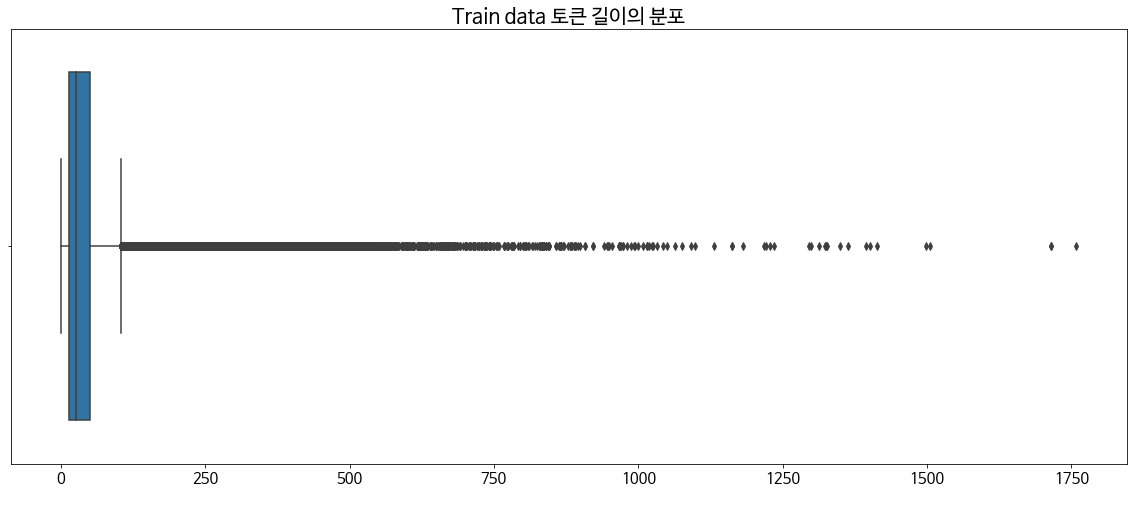

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(x='token_len', data=data.query('token_len<2000'))
plt.title('Train data 토큰 길이의 분포', fontsize=20)
plt.xlabel(' ')
plt.xticks(fontsize=15)
plt.show()

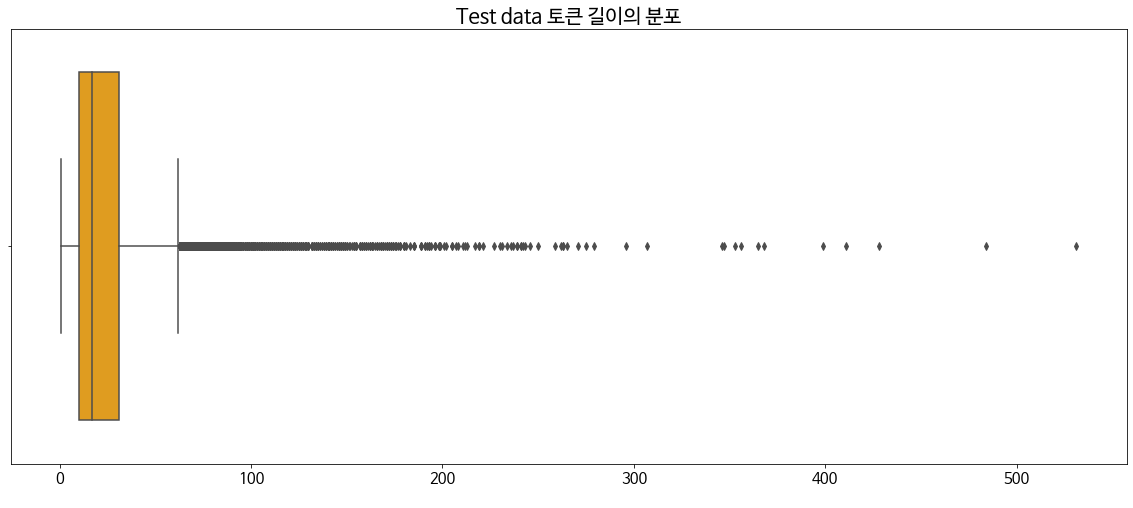

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(x='token_len', data=test.query('token_len<10000'), color='orange')
plt.title('Test data 토큰 길이의 분포', fontsize=20)
plt.xlabel(' ')
plt.xticks(fontsize=15)
plt.show()

# 4. 대분류별 중복 토큰

In [ ]:
import nltk

In [ ]:
total_tok_data = []
for dat in data['token']:
  total_tok_data+=dat

text = nltk.Text(total_tok_data)

In [ ]:
common = text.vocab().most_common(14)

In [ ]:
'판매업' in list(dict(common).keys())

True

In [ ]:
cd = pd.DataFrame(common, columns=['token', 'count'])

In [ ]:
cd.columns

Index(['token', 'count'], dtype='object')

In [ ]:
cd['count'] = cd['count'].astype('int')

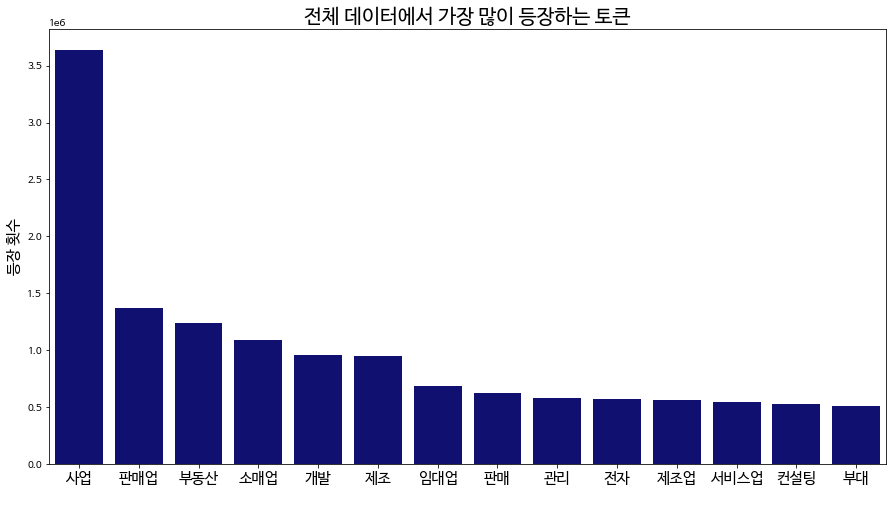

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data=cd, x='token', y='count', color='#000080')
plt.title('전체 데이터에서 가장 많이 등장하는 토큰', fontsize=20)
plt.xlabel(' ')
plt.ylabel('등장 횟수', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

### 공통된 대분류 단어 보여주기
- 판매업
- 서비스업
- 부동산
- 소매업, 임대업

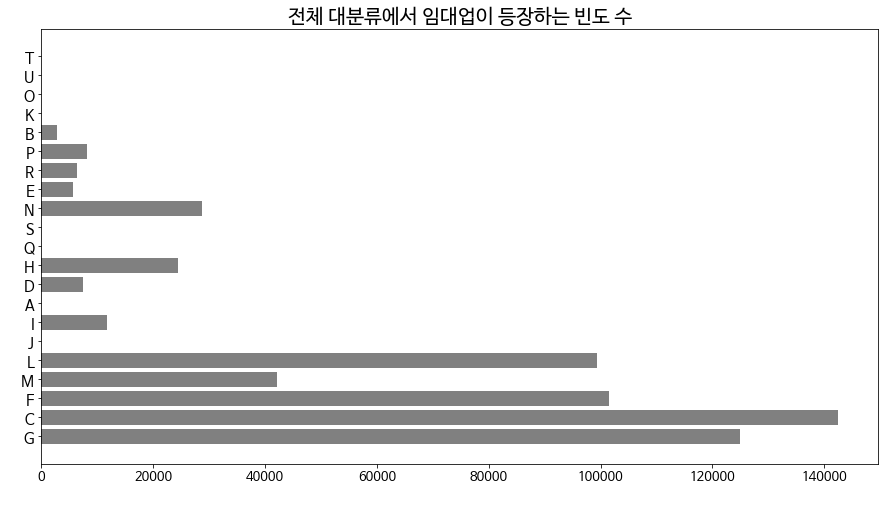

CPU times: user 1min 10s, sys: 308 ms, total: 1min 10s
Wall time: 1min 10s


In [ ]:
%%time
result = []
word = '임대업'
common_dt = pd.DataFrame(data.big.unique(), columns=['대분류'])

for bigs in tqdm_notebook(data.big.unique()):
    total_tok_data = []
    for dat in data[data['big']==bigs]['token']:
        total_tok_data+=dat
    text = nltk.Text(total_tok_data)
    a = text.vocab().most_common(20)
    
    if word in list(dict(a).keys()):        # 우선 포함 여부 확인 
      for i in range(len(a)):
        if a[i][0]==word:
          result.append(a[i][1])   # 넣기만 하면 반복문 break
          break

    else:
      result.append(0)

common_dt['등장횟수'] = result

# horizontal bar plot
plt.figure(figsize=(15,8))
plt.barh(common_dt['대분류'], common_dt['등장횟수'], color='gray')
plt.title('전체 대분류에서 ' + word + '이 등장하는 빈도 수', fontsize=20)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.show()

# 대분류 분포 plot

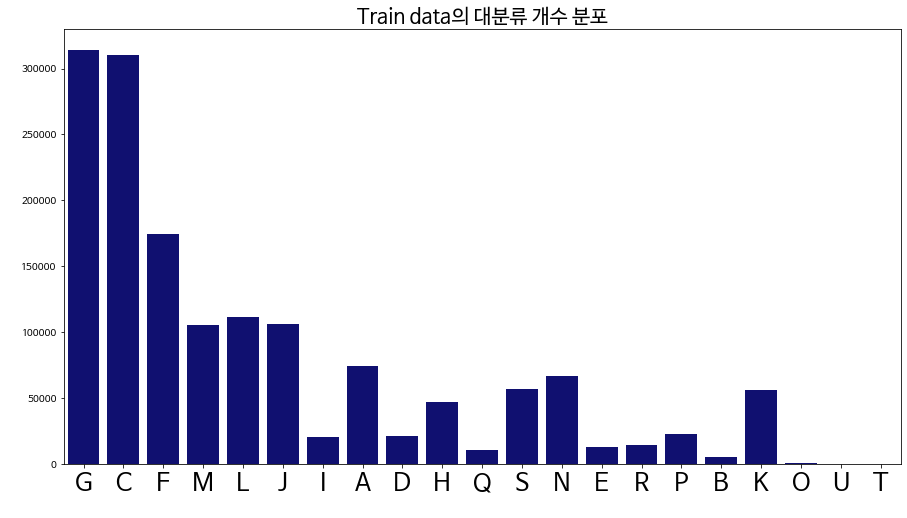

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(data=data, x='big', color='#000080')
plt.title('Train data의 대분류 개수 분포', fontsize=20)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks(fontsize=25)
plt.show()

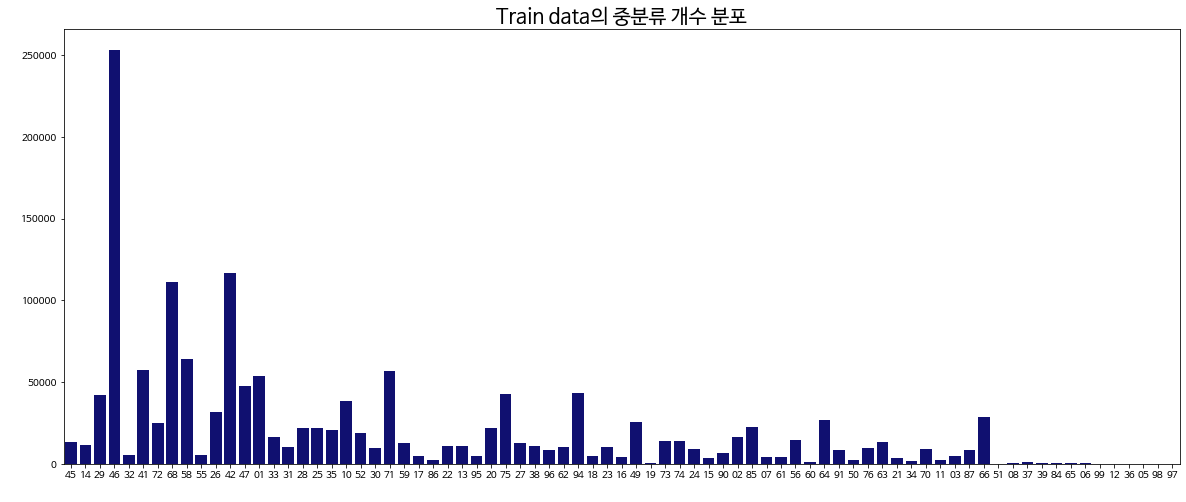

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data=data, x='middle', color='#000080')
plt.title('Train data의 중분류 개수 분포', fontsize=20)
plt.xlabel(' ')
plt.ylabel(' ')
# plt.xticks(fontsize=25)
plt.show()